In [1]:
from feos.dft import *
from feos.pcsaft import PcSaftParameters

import matplotlib.pyplot as plt
import si_units as si
import numpy as np
from concurrent.futures import ProcessPoolExecutor

# the following is only needed if you processpool executor
# does not start multiple processes
#import psutil
#p = psutil.Process()
#p.cpu_affinity(list(range(psutil.cpu_count())))

In [2]:
params = PcSaftParameters.from_json(["methanol"], "../../parameters/pcsaft/rehner2020.json")
func = HelmholtzEnergyFunctional.pcsaft(params)

# Phase equilibria in pores

In [3]:
%%time
potential = ExternalPotential.LJ93(3.0, 100.0, 0.08)
pore = Pore1D(Geometry.Cartesian, 20*si.ANGSTROM, potential)
solver = DFTSolver().newton()

pmin = 0.2*si.BAR
pmax = 2.5*si.BAR
pressure_vec = si.linspace(pmin, pmax, 151)
pressures = np.array([0.3, 0.6, 1.0, 1.2, 1.5, 2.0]) * si.BAR

isotherm1 = Adsorption1D.adsorption_isotherm(func, 350*si.KELVIN, pressure_vec, pore, solver=solver)
points1 = Adsorption1D.adsorption_isotherm(func, 350*si.KELVIN, pressures, pore, solver=solver)

isotherm2 = Adsorption1D.desorption_isotherm(func, 350*si.KELVIN, pressure_vec, pore, solver=solver)
points2 = Adsorption1D.desorption_isotherm(func, 350*si.KELVIN, pressures, pore, solver=solver)

isotherm3 = Adsorption1D.equilibrium_isotherm(func, 350*si.KELVIN, pressure_vec, pore, solver=solver)
points3 = Adsorption1D.equilibrium_isotherm(func, 350*si.KELVIN, pressures, pore, solver=solver)

equilibrium = Adsorption1D.phase_equilibrium(func, 350*si.KELVIN, pmin, pmax, pore, solver=solver)

CPU times: user 8.5 s, sys: 40.9 ms, total: 8.54 s
Wall time: 8.51 s


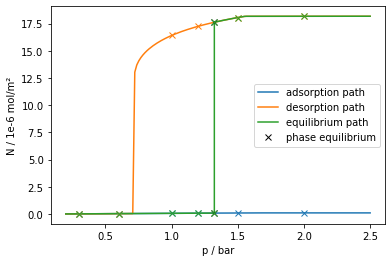

In [4]:
plt.plot(isotherm1.pressure/si.BAR, isotherm1.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.plot(isotherm2.pressure/si.BAR, isotherm2.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.plot(isotherm3.pressure/si.BAR, isotherm3.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.plot(equilibrium.pressure/si.BAR, equilibrium.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2), 'xk')
plt.gca().set_prop_cycle(None)
plt.plot(points1.pressure/si.BAR, points1.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2), 'x')
plt.plot(points2.pressure/si.BAR, points2.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2), 'x')
plt.plot(points3.pressure/si.BAR, points3.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2), 'x')
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

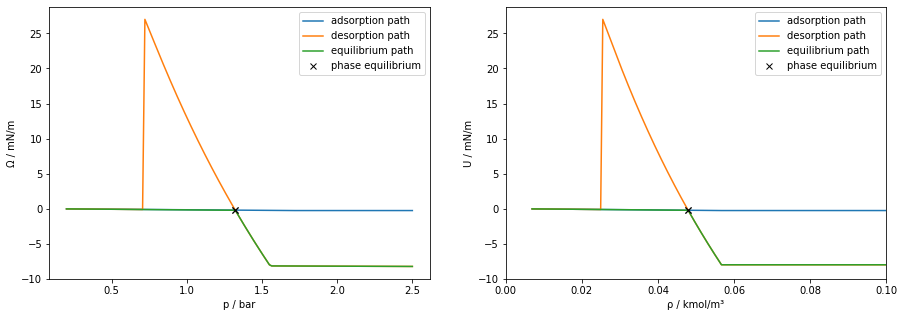

In [5]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm1.pressure/si.BAR, isotherm1.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[0].plot(isotherm2.pressure/si.BAR, isotherm2.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[0].plot(isotherm3.pressure/si.BAR, isotherm3.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[0].plot(equilibrium.pressure/si.BAR, equilibrium.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER), 'xk')
ax[0].set_xlabel('p / bar')
ax[0].set_ylabel('Ω / mN/m')
ax[0].legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

ax[1].plot(StateVec([p.bulk for p in isotherm1.profiles]).density/(si.KILO*si.MOL/si.METER**3), isotherm1.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[1].plot(StateVec([p.bulk for p in isotherm2.profiles]).density/(si.KILO*si.MOL/si.METER**3), isotherm2.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[1].plot(StateVec([p.bulk for p in isotherm3.profiles]).density/(si.KILO*si.MOL/si.METER**3), isotherm3.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER))
ax[1].plot(StateVec([p.bulk for p in equilibrium.profiles]).density/(si.KILO*si.MOL/si.METER**3), equilibrium.grand_potential/(si.MILLI*si.NEWTON*si.ANGSTROM**2/si.METER), 'xk')
ax[1].set_xlim(0,0.1)
ax[1].set_xlabel('ρ / kmol/m³')
ax[1].set_ylabel('U / mN/m')
ax[1].legend(['adsorption path', 'desorption path', 'equilibrium path', 'phase equilibrium']);

# Enthalpy of adsorption

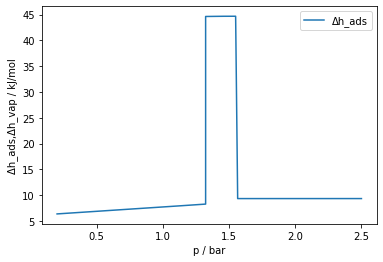

In [6]:
plt.plot(isotherm3.pressure/si.BAR, isotherm3.enthalpy_of_adsorption/(si.KILO*si.JOULE/si.MOL))

vle = PhaseEquilibrium.pure(func, 350*si.KELVIN)
#h_vap = (vle.vapor.molar_enthalpy() - vle.liquid.molar_enthalpy())/(si.KILO*si.JOULE/si.MOL)
#plt.plot([pmin/si.BAR, pmax/si.BAR],[h_vap,h_vap])
plt.xlabel('p / bar')
plt.ylabel('Δh_ads,Δh_vap / kJ/mol')
plt.legend(['Δh_ads', 'Δh_vap']);

# Variation of pore width

In [7]:
%%time
def plt_iso(L):
    isotherm = Adsorption1D.equilibrium_isotherm(func, 350*si.KELVIN, si.linspace(0.5*si.BAR, 1.6*si.BAR, 100), Pore1D(Geometry.Cartesian, L, potential), solver=DFTSolver().newton())
    return isotherm.pressure, isotherm.total_adsorption

L_vec = si.linspace(10*si.ANGSTROM,40*si.ANGSTROM,7)
with ProcessPoolExecutor(1) as ex:
    isotherms = [i for i in ex.map(plt_iso, L_vec)]

CPU times: user 6.12 ms, sys: 11.9 ms, total: 18 ms
Wall time: 12.6 s


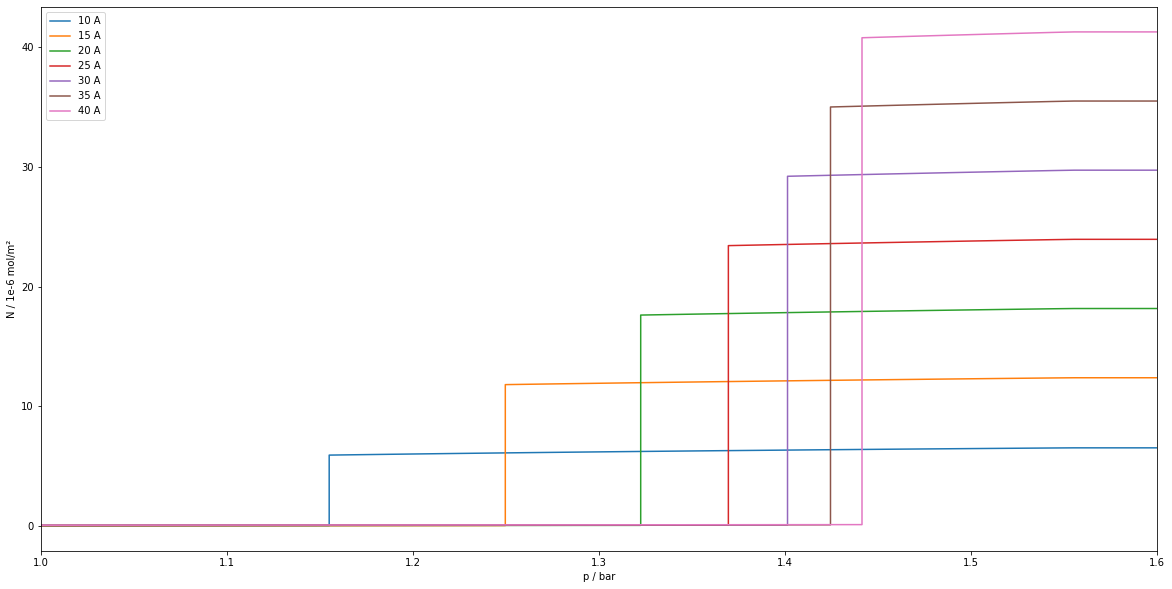

In [8]:
f, ax = plt.subplots(figsize=(20,10))
for p,a in isotherms:
    ax.plot(p/si.BAR, a/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f'{w/si.ANGSTROM:g} A' for w in L_vec])
plt.xlim(1,1.6);

# Variation of $\varepsilon$-parameter

In [9]:
%%time
def plt_iso(epsilon):
    potential = ExternalPotential.LJ93(3.0, epsilon, 0.08)
    isotherm = Adsorption1D.equilibrium_isotherm(func, 350*si.KELVIN, si.linspace(0.5*si.BAR, 1.6*si.BAR, 100), Pore1D(Geometry.Cartesian, 20*si.ANGSTROM, potential), solver=DFTSolver().newton())
    return isotherm.pressure, isotherm.total_adsorption

eps_vec = np.linspace(70,150,9)
with ProcessPoolExecutor() as ex:
    isotherms = [i for i in ex.map(plt_iso, eps_vec)]

CPU times: user 20.3 ms, sys: 65.9 ms, total: 86.2 ms
Wall time: 3.17 s


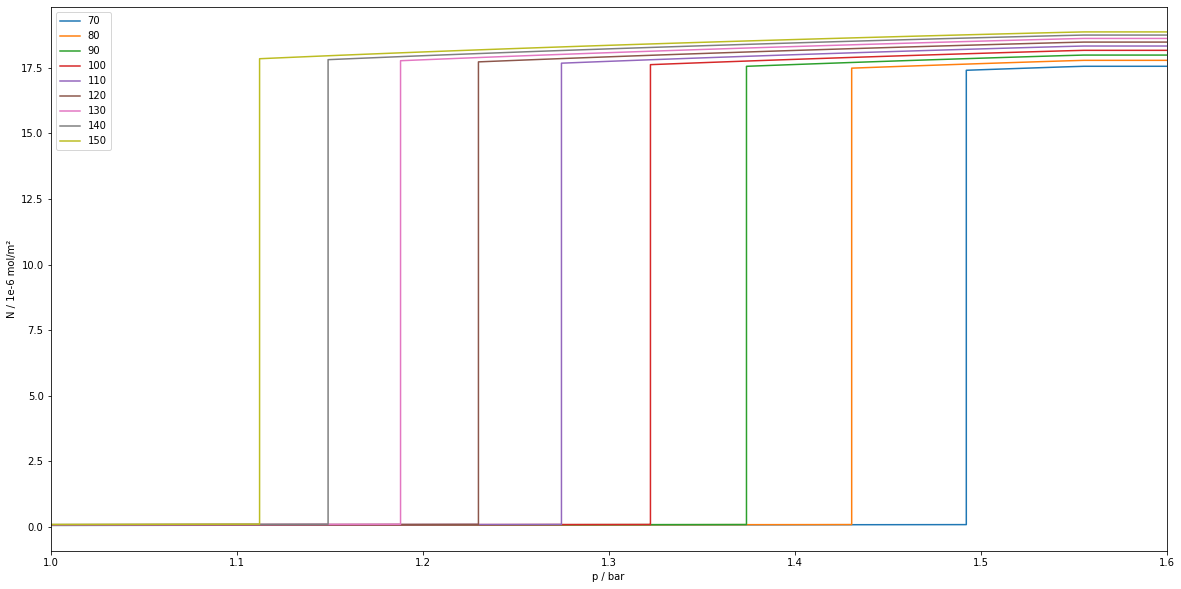

In [10]:
f, ax = plt.subplots(figsize=(20,10))
for p,a in isotherms:
    ax.plot(p/si.BAR, a/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f'{e:g}' for e in eps_vec])
plt.xlim(1,1.6);

# Variation of temperature

In [11]:
%%time
def plt_iso(T):
    potential = ExternalPotential.LJ93(3.0, 150., 0.08)
    psat = PhaseEquilibrium.pure(func, T).liquid.pressure()
    pmin = psat / 100
    pmax = psat * 2
    isotherm = Adsorption1D.equilibrium_isotherm(func, T, si.linspace(pmin, pmax, 200), Pore1D(Geometry.Cartesian, 20*si.ANGSTROM, potential), solver=DFTSolver().newton())
    return isotherm.pressure, isotherm.total_adsorption

T_vec = si.linspace(290*si.KELVIN,430*si.KELVIN,15)
with ProcessPoolExecutor() as ex:
    isotherms = [i for i in ex.map(plt_iso, T_vec)]

CPU times: user 1.22 ms, sys: 152 ms, total: 153 ms
Wall time: 16.8 s


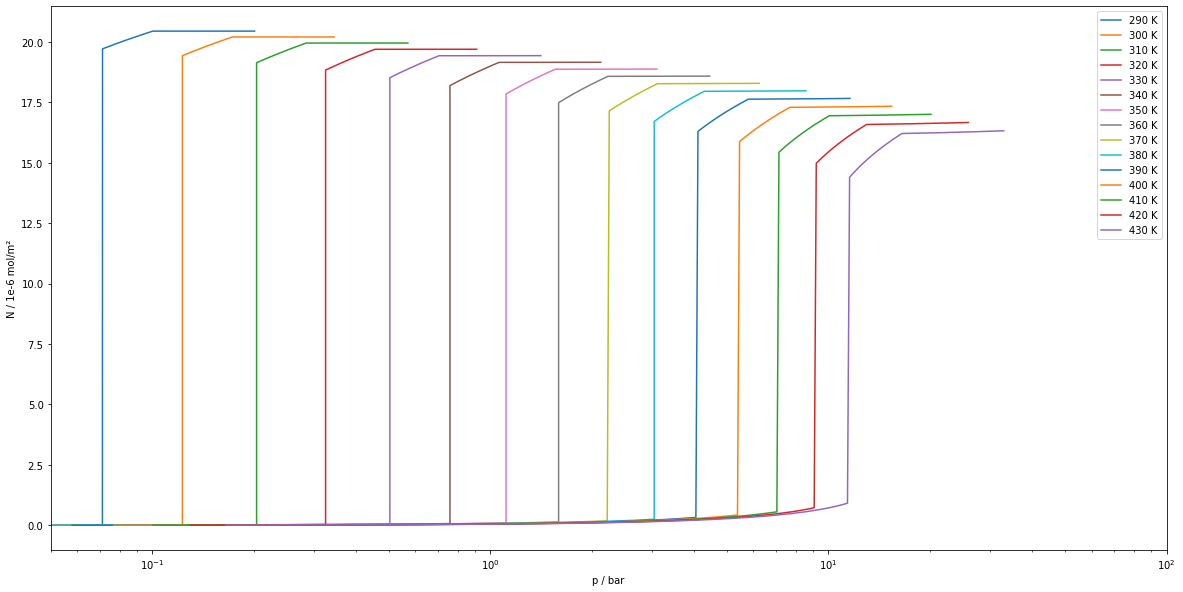

In [12]:
f, ax = plt.subplots(figsize=(20,10))
for p,a in isotherms:
    ax.semilogx(p/si.BAR, a/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
plt.xlabel('p / bar')
plt.ylabel('N / 1e-6 mol/m²')
plt.legend([f"{T/si.KELVIN:g} K" for T in T_vec])
plt.xlim(0.05,100);

# Binary mixture

In [13]:
mix = HelmholtzEnergyFunctional.pcsaft(PcSaftParameters.from_json(["methanol", "ethanol"], "../../parameters/pcsaft/rehner2020.json"))
methanol = HelmholtzEnergyFunctional.pcsaft(PcSaftParameters.from_json(["methanol"], "../../parameters/pcsaft/rehner2020.json"))
ethanol  = HelmholtzEnergyFunctional.pcsaft(PcSaftParameters.from_json(["ethanol"], "../../parameters/pcsaft/rehner2020.json"))

In [14]:
potential = ExternalPotential.LJ93(3.0, 100.0, 0.08)
pmin = 0.2*si.BAR
pmax = 1.8*si.BAR
solver = DFTSolver().newton(tol=1e-10)

isotherm_ethanol = Adsorption1D.equilibrium_isotherm(ethanol, 350*si.KELVIN, si.linspace(pmin, pmax, 51), Pore1D(Geometry.Cartesian, 15*si.ANGSTROM, potential), solver=solver)
isotherm_methanol = Adsorption1D.equilibrium_isotherm(methanol, 350*si.KELVIN, si.linspace(pmin, pmax, 51), Pore1D(Geometry.Cartesian, 15*si.ANGSTROM, potential), solver=solver)
isotherm_mix = Adsorption1D.equilibrium_isotherm(mix, 350*si.KELVIN, si.linspace(pmin, pmax, 51), Pore1D(Geometry.Cartesian, 15*si.ANGSTROM, potential), np.array([0.5, 0.5]), solver=solver)

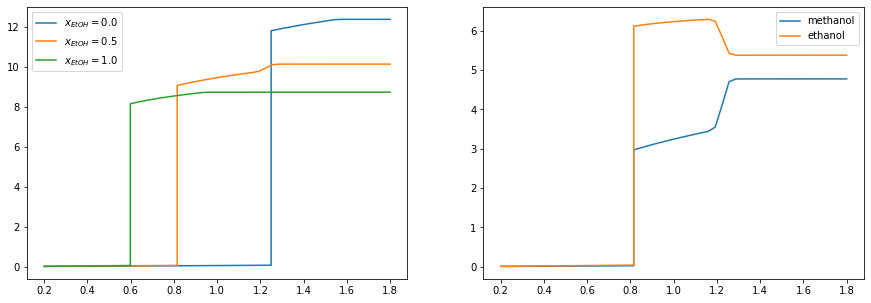

In [15]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm_methanol.pressure/si.BAR, isotherm_methanol.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
ax[0].plot(isotherm_mix.pressure/si.BAR, isotherm_mix.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
ax[0].plot(isotherm_ethanol.pressure/si.BAR, isotherm_ethanol.total_adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2))
ax[0].legend(['$x_{EtOH}=0.0$', '$x_{EtOH}=0.5$', '$x_{EtOH}=1.0$']);

ax[1].plot(isotherm_mix.pressure/si.BAR, (isotherm_mix.adsorption/(si.MICRO*si.MOL*si.ANGSTROM**2/si.METER**2)).T)
ax[1].legend(['methanol', 'ethanol']);

In [16]:
equilibrium = Adsorption1D.phase_equilibrium(mix, 350*si.KELVIN, pmin, pmax, Pore1D(Geometry.Cartesian, 15*si.ANGSTROM, potential), np.array([0.5, 0.5]), solver=solver)

(0.0, 17.0)

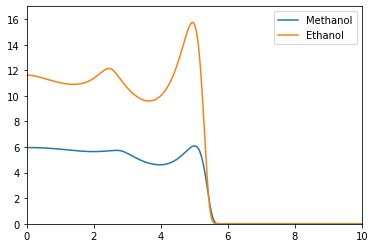

In [17]:
plt.plot(equilibrium.profiles[1].r/si.ANGSTROM, (equilibrium.profiles[1].density/(si.KILO*si.MOL/si.METER**3)).T)
plt.legend(["Methanol", "Ethanol"])
plt.xlim(0,10)
plt.ylim(0,17)

# External potentials

### Lennard-Jones 9-3

In [18]:
rho = 3.0e4
potential = ExternalPotential.LJ93(3.0, 90, 0.08)
s = State(func, 350*si.KELVIN, density=rho*si.MOL/si.METER**3)
profile = Pore1D(Geometry.Cartesian, 20*si.ANGSTROM, potential).initialize(s).solve(solver=solver)

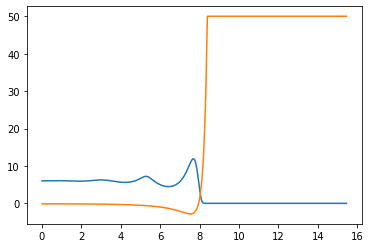

In [19]:
plt.plot(profile.r / si.ANGSTROM, (profile.density / (si.MOL  / si.METER**3))[0] / 5000)
plt.plot(profile.r / si.ANGSTROM, profile.external_potential[0])

### Double Well

In [20]:
potential = ExternalPotential.DoubleWell(3.0, 25, 150, 0.08)
s = State(func, 350*si.KELVIN, density=rho*si.MOL/si.METER**3)
profile = Pore1D(Geometry.Cartesian, 40*si.ANGSTROM, potential).initialize(s).solve(solver=solver)

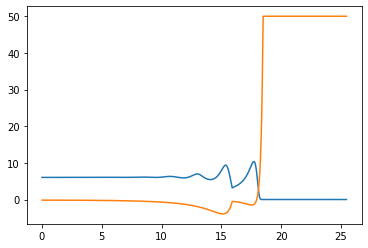

In [21]:
plt.plot(profile.r / si.ANGSTROM, (profile.density / (si.MOL  / si.METER**3))[0] / 5000)
plt.plot(profile.r / si.ANGSTROM, profile.external_potential[0])

# DFTSolver options

In [22]:
# create a list of solvers that are called consecutively
solver = DFTSolver().newton()
solver

|solver|max_iter|tol|
|-|-:|-:|
|Newton (max_iter_gmres=200)|50|1e-11|